# Hyper-parameter Tuning in Keras

Used a sample in built dataset **MNIST** to demonstrate how endless of parameters could be tuned using scikit learn wrapper for keras.

Author: Ashish Chaudhary

LinkedIn: https://www.linkedin.com/in/ashish-chaudhary-150353196/

### Caution: 

* Please make sure gpu support is enabled. On Colab, use gpu runtime. 
* Script could take more than 5 minutes to run.



In [1]:
from datetime import datetime

start_time = datetime.now()

In [2]:
def initialize():
    
    import tensorflow as tf
    
    print("Tensorflow built with CUDA: ", end="")
    print(tf.test.is_built_with_cuda())
        
    try:
        print("Using the following hardware:")
        print(tf.config.experimental.get_device_details(
            tf.config.list_physical_devices('GPU')[0]))
    except:
        print("Unknown GPU")
        
    assert tf.test.is_built_with_cuda(), "Please make sure CUDA gpu support is enabled"

In [3]:
initialize()

Tensorflow built with CUDA: True
Using the following hardware:
{'device_name': 'NVIDIA GeForce RTX 2060', 'compute_capability': (7, 5)}


### Uncomment below code cell to install scikeras

In [4]:
# !pip install scikeras

In [5]:
import tensorflow as tf
import scikeras
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

from IPython.display import display

In [6]:
def build_model(
    n_hidden=1,
    n_neurons=32,
    learning_rate=0.001,
    dropout=0.2):
    
    
    """Helper function to build the model architecture. 
    Uses: To aid in hyperparameter tuning and search.
    
    Parameters:
    ---------
        n_hidden: number of hidden layers
            Default: 1
        n_neurons: number of neurons in a layer
            Default: 32
        learning_rate: learning rate to use in adam optimizer
            Default: 0.001
        dropout: Dropout regularization
            Default: 0.2
            
    Returns:
    -------
        Compiled Keras Model
    """
    import tensorflow as tf
    
    # Sequential model
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    
    # Add 1 dense layer according to n_hidden with dropout probability
    # according to dropout parameter
    for i in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
        model.add(tf.keras.layers.Dropout(dropout))
    
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    
    # Compile the model according to the learning rate provided as
    # learning_rate parameter of the helper function build_model 
    model.compile(
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    )
    
    return model

In [7]:
def train_and_plot_mnist(model):
    
    """Function to train the provided keras model and
    plot the respective history (loss and accuracy)
    
    Parameters:
    ----------
        model: Keras model
        
    Returns:
    -------
        History object containing loss and accuracy
    """
    
    # Load mnist data
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # Normalize the range 0-255 to 0-1
    X_train, X_test = X_train/255.0, X_test/255.0
    
    # Model training
    results = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=256,
        epochs=10, 
        verbose=0
    )
    
    # Create dataframe for loss and accuracy
    df = pd.DataFrame(results.history)
    display(df)
    
    # Plot metrics for train and validation set
    df.plot(figsize=(8,5))
    plt.gca().set_ylim(0,1)
    plt.yticks(np.arange(0, 1.05, 0.05))
    plt.xticks(np.arange(0, 10, 1))
    plt.show()
    
    return results

In [8]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train/255.0, X_test/255.0

Here's how some sample images in mnist dataset looks

Ground Truth Label: 5


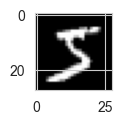

Ground Truth Label: 0


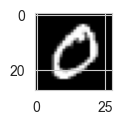

In [9]:
for index in [0,1]:
    print("Ground Truth Label:", y_train[index])

    plt.figure(figsize=(1,1))
    plt.imshow(X_train[index], cmap=plt.cm.gray)
    plt.show()

# Hyper-parameter search space


We will one by one, try different combinations of hidden layers, number of neurons, learning rate in Adam optimizer, and dropout regularization

* Layers: 1,2,3

* Neurons: 64, 128, 256

* Learning rate: 0.01, 0.001, 0.005, 0.0001

* Dropout probability: 0, 0.2, 0.4, 0.6, 0.8


We will use first, randomized search with 16 fits to **observe training time** and parameter space behavior and then accordingly use GridSearchCV.

# Randomized Search CV

In [10]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train/255.0, X_test/255.0


# Hyper parameter combinations: 3x3x4x5
# Number of random fits selected: 8 
# x 2 (cross-validation fits)
# Total fits: 16

param_distrib = {
    "n_hidden": [1, 2, 3],
    "n_neurons": [64, 128, 256],
    "learning_rate": [0.01, 0.001, 0.005, 0.0001],
    "dropout": np.arange(0, 0.9, 0.2)
}

display(param_distrib)

# Scikit learn wrapper for Keras
# It'll take a custom model building function to work
# We have build_model as our helper function
# Other parameters like n_hidden to KerasClassifier call will be
# used as arguments inside our helper function (build_model)
keras_clf = KerasClassifier(
    build_model,
    n_hidden=1,
    n_neurons=64,
    learning_rate=0.001,
    dropout=0.2
)

# While using scikit learn wrappers for keras
# pass a keras custom model and other search parameters
# like dict containing hyper-parameter combinations
randomized_search = RandomizedSearchCV(
    keras_clf,
    param_distrib,
    n_iter=8,
    cv=2,
    verbose=2
)

# Batch size 1024 used, please reduce if error comes
history = randomized_search.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=1024,
    verbose=0
)

display(randomized_search.best_params_)
display(randomized_search.best_score_)

{'n_hidden': [1, 2, 3],
 'n_neurons': [64, 128, 256],
 'learning_rate': [0.01, 0.001, 0.005, 0.0001],
 'dropout': array([0. , 0.2, 0.4, 0.6, 0.8])}

Fitting 2 folds for each of 8 candidates, totalling 16 fits
938/938 [==============================] - 1s 872us/step
[CV] END dropout=0.0, learning_rate=0.0001, n_hidden=3, n_neurons=128; total time=   4.2s
938/938 [==============================] - 1s 846us/step
[CV] END dropout=0.0, learning_rate=0.0001, n_hidden=3, n_neurons=128; total time=   2.9s
938/938 [==============================] - 1s 749us/step
[CV] END dropout=0.4, learning_rate=0.0001, n_hidden=1, n_neurons=128; total time=   2.9s
938/938 [==============================] - 1s 741us/step
[CV] END dropout=0.4, learning_rate=0.0001, n_hidden=1, n_neurons=128; total time=   2.8s
938/938 [==============================] - 1s 787us/step
[CV] END dropout=0.8, learning_rate=0.001, n_hidden=2, n_neurons=64; total time=   3.0s
938/938 [==============================] - 1s 780us/step
[CV] END dropout=0.8, learning_rate=0.001, n_hidden=2, n_neurons=64; total time=   3.0s
938/938 [==============================] - 1s 796us/step
[CV] 

{'n_neurons': 64, 'n_hidden': 3, 'learning_rate': 0.005, 'dropout': 0.0}

0.96165

In [11]:
display(randomized_search.best_params_)
display(randomized_search.best_score_)

{'n_neurons': 64, 'n_hidden': 3, 'learning_rate': 0.005, 'dropout': 0.0}

0.96165

In [12]:
print("DOne")

DOne


# Caution: GridSearchCV

We have now a basic idea of which hyper parameters to search in gridsearchcv.

**Parameter combinations:**

3x2x2x3 (x2 cross-validation fits)

**Combinations: 36**

**Total fits: 72 fits**

In [13]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train/255.0, X_test/255.0

param_distrib = {
    "n_hidden": [1, 2, 3],
    "n_neurons": [128, 256],
    "learning_rate": [0.001, 0.005],
    "dropout": [0.1, 0.2, 0.3]
}

print("Parameter search range:")
display(param_distrib)

keras_clf = KerasClassifier(
    build_model,
    n_hidden=1,
    n_neurons=32,
    learning_rate=0.001,
    dropout=0.2
)

grid = GridSearchCV(
    keras_clf,
    param_distrib,
    cv=2,
    verbose=2
)

# Batch size 2048 used, please reduce if error comes
history_grid = grid.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=2048,
    verbose=0
)

Parameter search range:


{'n_hidden': [1, 2, 3],
 'n_neurons': [128, 256],
 'learning_rate': [0.001, 0.005],
 'dropout': [0.1, 0.2, 0.3]}

Fitting 2 folds for each of 36 candidates, totalling 72 fits
938/938 [==============================] - 1s 789us/step
[CV] END dropout=0.1, learning_rate=0.001, n_hidden=1, n_neurons=128; total time=   2.7s
938/938 [==============================] - 1s 745us/step
[CV] END dropout=0.1, learning_rate=0.001, n_hidden=1, n_neurons=128; total time=   2.6s
938/938 [==============================] - 1s 727us/step
[CV] END dropout=0.1, learning_rate=0.001, n_hidden=1, n_neurons=256; total time=   2.7s
938/938 [==============================] - 1s 793us/step
[CV] END dropout=0.1, learning_rate=0.001, n_hidden=1, n_neurons=256; total time=   2.7s
938/938 [==============================] - 1s 882us/step
[CV] END dropout=0.1, learning_rate=0.001, n_hidden=2, n_neurons=128; total time=   2.8s
938/938 [==============================] - 1s 777us/step
[CV] END dropout=0.1, learning_rate=0.001, n_hidden=2, n_neurons=128; total time=   2.7s
938/938 [==============================] - 1s 1ms/step
[CV] END

938/938 [==============================] - 1s 853us/step
[CV] END dropout=0.3, learning_rate=0.001, n_hidden=3, n_neurons=128; total time=   2.9s
938/938 [==============================] - 1s 860us/step
[CV] END dropout=0.3, learning_rate=0.001, n_hidden=3, n_neurons=128; total time=   2.9s
938/938 [==============================] - 1s 874us/step
[CV] END dropout=0.3, learning_rate=0.001, n_hidden=3, n_neurons=256; total time=   3.0s
938/938 [==============================] - 1s 842us/step
[CV] END dropout=0.3, learning_rate=0.001, n_hidden=3, n_neurons=256; total time=   2.9s
938/938 [==============================] - 1s 760us/step
[CV] END dropout=0.3, learning_rate=0.005, n_hidden=1, n_neurons=128; total time=   2.5s
938/938 [==============================] - 1s 757us/step
[CV] END dropout=0.3, learning_rate=0.005, n_hidden=1, n_neurons=128; total time=   2.9s
938/938 [==============================] - 1s 719us/step
[CV] END dropout=0.3, learning_rate=0.005, n_hidden=1, n_neurons=25

In [14]:
print("Idle")

Idle


In [15]:
grid.best_score_

0.97205

In [16]:
grid.best_params_

{'dropout': 0.2, 'learning_rate': 0.005, 'n_hidden': 3, 'n_neurons': 256}

# Finalized model with best parameters

In [17]:
help(build_model)

Help on function build_model in module __main__:

build_model(n_hidden=1, n_neurons=32, learning_rate=0.001, dropout=0.2)
    Helper function to build the model architecture. 
    Uses: To aid in hyperparameter tuning and search.
    
    Parameters:
    ---------
        n_hidden: number of hidden layers
            Default: 1
        n_neurons: number of neurons in a layer
            Default: 32
        learning_rate: learning rate to use in adam optimizer
            Default: 0.001
        dropout: Dropout regularization
            Default: 0.2
            
    Returns:
    -------
        Compiled Keras Model



In [18]:
help(train_and_plot_mnist)

Help on function train_and_plot_mnist in module __main__:

train_and_plot_mnist(model)
    Function to train the provided keras model and
    plot the respective history (loss and accuracy)
    
    Parameters:
    ----------
        model: Keras model
        
    Returns:
    -------
        History object containing loss and accuracy



,loss,accuracy,val_loss,val_accuracy
0,0.258477,0.919700,0.121039,0.9621
1,0.127475,0.961317,0.091437,0.9718
2,0.099124,0.969467,0.083624,0.9737
3,0.087651,0.972317,0.085175,0.9741
4,0.076660,0.976617,0.088964,0.9732
5,0.072418,0.976683,0.078472,0.9756
6,0.070097,0.978150,0.082376,0.9765
7,0.060604,0.980467,0.084961,0.9776
8,0.061465,0.980917,0.084745,0.9783
9,0.059583,0.981367,0.098607,0.9744


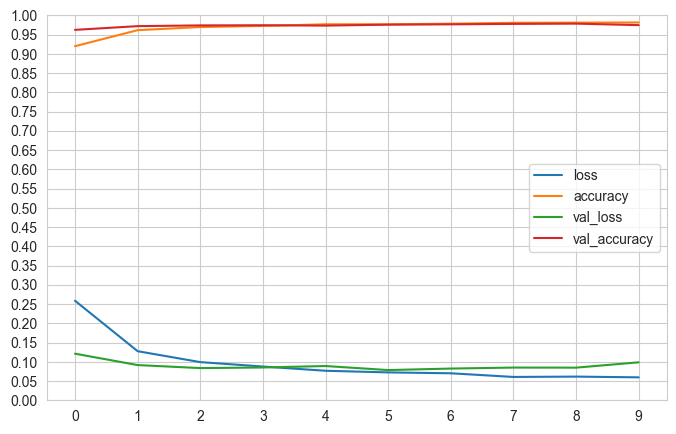

In [19]:
model2 = build_model(
    learning_rate=0.005,
    n_hidden=2,
    n_neurons=256,
    dropout=0.2
)

results = train_and_plot_mnist(model2)

In [20]:
model2.summary()

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_90 (Flatten)        (None, 784)               0         
                                                                 
 dense_272 (Dense)           (None, 256)               200960    
                                                                 
 dropout_182 (Dropout)       (None, 256)               0         
                                                                 
 dense_273 (Dense)           (None, 256)               65792     
                                                                 
 dropout_183 (Dropout)       (None, 256)               0         
                                                                 
 dense_274 (Dense)           (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-t

# Classification Report

In [21]:
y_pred_prob = model2.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred

313/313 [==============================] - 0s 795us/step


array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [22]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [23]:
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.98      0.98      1010
           4       0.97      0.98      0.97       982
           5       0.96      0.98      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.98      0.94      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 973    1    0    0    0    3    0    0    2    1]
 [   0 1126    5    1    0    1    1    0    1    0]
 [  11    0 1001    2    2    0    1    3   12    0]
 [   0    0    4  994    0    5    0    4    2    1]
 [   1    0    2    0  963    0    5    2    2    7]
 [   2    0    0   10    0  872    5    0    3    0]
 [   8    3    0    1    4    4  937    0    1    0]
 [   2    7   14    2    3    1    0  992    3    4]
 [   8    1    2    6    5   10    2    1  937    2]
 [   4    6    0    6   20   11    1    7    5  949]]


## To find the errors

**Highlighted points in the below graph are our errors made by the model**

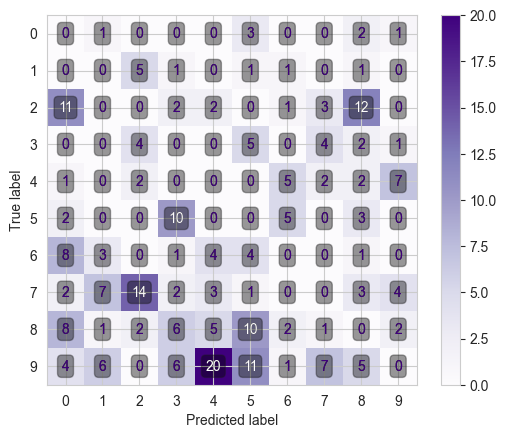

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)

np.fill_diagonal(conf_matrix, 0)

fig, ax = plt.subplots()

for (row, col), value in np.ndenumerate(conf_matrix):
    ax.text(col, row, value, ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='black', 
                      edgecolor='0.1', alpha=0.4))

disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Purples, ax=ax)
plt.show()

In [26]:
def plot_digit(index):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(X_test[i], cmap=plt.cm.gray)
    plt.title("True Label: {}\nPredicted Label: {}".format(y_test[i], y_pred[i]))
    plt.show()

In [27]:
misclassified_idx = np.where(y_test != y_pred)[0]

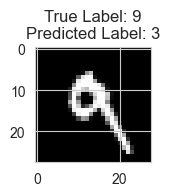

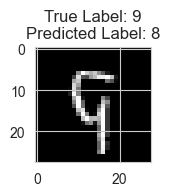

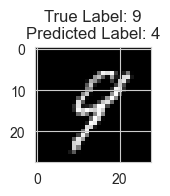

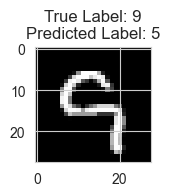

In [28]:
for i in misclassified_idx[:4]:
    plot_digit(i)

In [29]:
end_time = datetime.now()
total_time = end_time - start_time

print("Total time to run the script:", 
      int(total_time.total_seconds()), "seconds")

Total time to run the script: 279 seconds
